In [1]:
import numpy as np
from pandas import read_csv, read_feather, concat
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# for drawing barchart, so we don't have to retype the following everytime
def draw_barchart(df, title):
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    df.plot(kind='bar')
    ax.set_xlabel("(Year, Month)")
    plt.xticks(rotation=60) 
    plt.title(title)
    plt.show()

In [2]:
def distance(lat1, lng1, lat2, lng2):
    #return distance as meter if you want km distance, remove "* 1000"
    radius = 6371

    dLat = (lat2-lat1) * np.pi / 180
    dLng = (lng2-lng1) * np.pi / 180

    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180

    val = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLng/2)\
    * np.sin(dLng/2) * np.cos(lat1) * np.cos(lat2)    
    ang = 2 * np.arctan2(np.sqrt(val), np.sqrt(1-val))
    return radius * ang

In [82]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = distance(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = distance(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = distance(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = distance(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = distance(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = distance(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon) 
    
    dataset['jfk_dist'] = concat([pickup_jfk, dropoff_jfk], axis=1).min(axis=1)
    #dataset['ewr_dist'] = concat([pickup_ewr, dropoff_ewr], axis=1).min(axis=1)
    #dataset['lga_dist'] = concat([pickup_lga, dropoff_lga], axis=1).min(axis=1)
    
    return dataset

In [90]:
def transform(train_df):
    
    # Remove missing values
    train_df = train_df.dropna(how = 'any', axis = 'rows')

    # Remove absurd passenger_count
    train_df = train_df[(train_df['passenger_count'] >= 1) &
                    (train_df['passenger_count'] <= 6)]
    #train_df['passenger_count'] = train_df.passenger_count.astype('uint8')

    # Remove passenger_count column
    train_df = train_df.drop(['passenger_count'], axis=1)

    # Remove negative and extreme fare_amount values
    train_df = train_df[(train_df['fare_amount'] >= 2.5) & (train_df['fare_amount'] <= 200)]
    print('Maximum fare_amount: %.1f' % train_df['fare_amount'].max())

    # Remove no displacements
    train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude'])]
    train_df = train_df[(train_df['pickup_longitude'] != train_df['dropoff_longitude'])]

    # Remove absurd displacements
    train_df = train_df[(train_df['pickup_longitude'] >= lng1min) &
                        (train_df['pickup_longitude'] <= lng1max)]
    train_df = train_df[(train_df['dropoff_longitude'] >= lng2min) &
                        (train_df['dropoff_longitude'] <= lng2max)]
    train_df = train_df[(train_df['pickup_latitude'] >= lat1min) &
                        (train_df['pickup_latitude'] <= lat1max)]
    train_df = train_df[(train_df['dropoff_latitude'] >= lat2min) &
                        (train_df['dropoff_latitude'] <= lat2max)]

    # Create new features - distance
    train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                                train_df['dropoff_latitude'], train_df['dropoff_longitude'])
    #train_df = train_df[train_df['dist'] <= 100]

    # Create new features - dayofweek,hour,month,year
    train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek.astype('uint8')
    train_df['weekend'] = np.where(train_df.dayofweek < 5,0,1).astype('uint8')
    train_df = train_df.drop(['dayofweek'], axis=1)
    train_df['hour'] = train_df['pickup_datetime'].dt.hour.astype('uint8')
    #train_df['hour_circ'] = np.where(train_df['hour'] <= 12,
    #                            (train_df['hour'] - 0)/12,
    #                            (24 - train_df['hour'])/12).astype('float32')
    #train_df['day'] = train_df['pickup_datetime'].dt.day.astype('uint8')
    #train_df['month'] = train_df['pickup_datetime'].dt.month.astype('uint8')
    train_df['year'] = train_df['pickup_datetime'].dt.year.astype('uint16')

    # Create features for special rates
    train_df['8pmto6am'] = np.where((train_df['hour'] >= 6) &
                                    (train_df['hour'] < 20),0,1).astype('uint8')
    #train_df['holiday'] = 
    train_df['rushhour'] = np.where((train_df['hour'] >= 16) &
                                    (train_df['hour'] < 20) &
                                    (train_df['weekend'] == 0),1,0).astype('uint8')
    train_df = train_df.drop(['hour'], axis=1)

    # Add minimum distances to the airports
    add_airport_dist(train_df)
    train_df['jfk_ride'] = np.where(train_df['jfk_dist'] < 1.5,1,0).astype('uint8')
    #train_df['ewr_ride'] = np.where(train_df['ewr_dist'] < 1.5,1,0).astype('uint8')
    #train_df['lga_ride'] = np.where(train_df['lga_dist'] < 1.5,1,0).astype('uint8')
    
    train_df['period'] = np.where(train_df['pickup_datetime'] < '2012-09-01',0,1).astype('uint8')
  
    # Save memory
    train_df = train_df.drop(['pickup_datetime'], axis=1)
    print(train_df.shape)
    #print('Maximum ride distance: %.1f' % train_df['dist'].max())
    #del train_df
    #return P1,P2
    return train_df

## Read Test Set

In [35]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)

lng1min = test_df.pickup_longitude.min()
lng2min = test_df.dropoff_longitude.min()
lat1min = test_df.pickup_latitude.min()
lat2min = test_df.dropoff_latitude.min()
#
lng1max = test_df.pickup_longitude.max()
lng2max = test_df.dropoff_longitude.max()
lat1max = test_df.pickup_latitude.max()
lat2max = test_df.dropoff_latitude.max()

In [6]:
print(test_df.shape)
test_df.describe()

(9914, 7)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


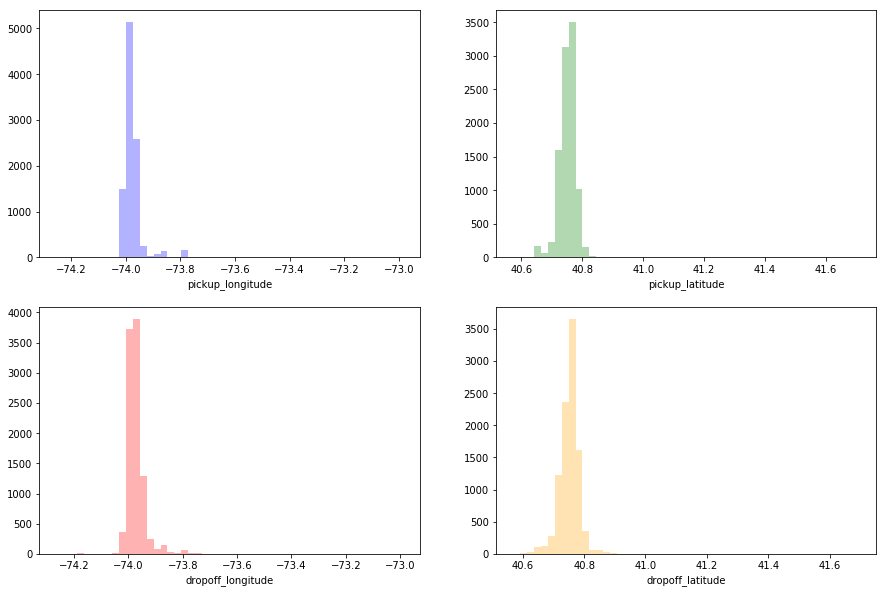

In [8]:
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
ax1.hist(test_df.pickup_longitude, bins=50, color = 'b', alpha = 0.3)
ax1.set_xlabel('pickup_longitude')
ax2 = plt.subplot(222)
ax2.hist(test_df.pickup_latitude, bins=50, color = 'g', alpha = 0.3)
ax2.set_xlabel('pickup_latitude')
ax3 = plt.subplot(223)
ax3.hist(test_df.dropoff_longitude, bins=50, color = 'r', alpha = 0.3)
ax3.set_xlabel('dropoff_longitude')
ax4 = plt.subplot(224)
ax4.hist(test_df.dropoff_latitude, bins=50, color = 'orange', alpha = 0.3)
ax4.set_xlabel('dropoff_latitude')
plt.show()

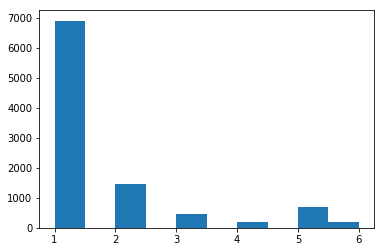

In [9]:
plt.hist(test_df.passenger_count)
plt.show()

In [10]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

In [11]:
NoDispLong = test_df[test_df.pickup_longitude == test_df.dropoff_longitude]
print(NoDispLong.shape)
NoDispLat = test_df[test_df.pickup_latitude == test_df.dropoff_latitude]
print(NoDispLat.shape)
NoDisp = test_df[(test_df.pickup_longitude == test_df.dropoff_longitude) &
                 (test_df.pickup_latitude == test_df.dropoff_latitude)]
print(NoDisp.shape)

(86, 7)
(85, 7)
(85, 7)


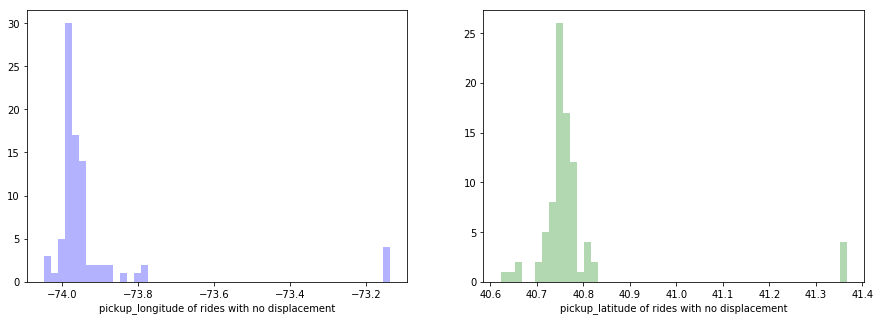

In [12]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.hist(NoDispLong.pickup_longitude, bins=50, color = 'b', alpha = 0.3)
ax1.set_xlabel('pickup_longitude of rides with no displacement')
ax2 = plt.subplot(122)
ax2.hist(NoDispLat.pickup_latitude, bins=50, color = 'g', alpha = 0.3)
ax2.set_xlabel('pickup_latitude of rides with no displacement')
plt.show()

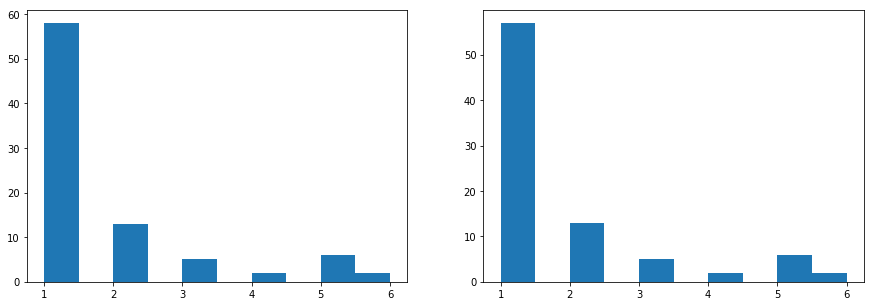

In [13]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1.hist(NoDispLong.passenger_count)
ax2 = plt.subplot(122)
ax2.hist(NoDispLat.passenger_count)
plt.show()

Rides with 'no displacements' seem to be normal rides. A pessanger take a taxi to take a tour in the region returning to the same point where he pickup the taxi.

In [14]:
# Add minimum distances to the airports
add_airport_dist(test_df)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,jfk_dist,ewr_dist,lga_dist
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,20.630787,16.776178,8.611599
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,19.647702,15.217920,11.446400
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,20.652459,16.988793,9.656367
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,21.747868,16.391035,9.200895
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,21.167442,16.235246,7.989082
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12,-73.960983,40.765547,-73.979177,40.740053,1,20.239385,16.818346,7.554750
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20,-73.949013,40.773204,-73.959622,40.770893,1,20.638334,19.648911,6.449174
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20,-73.777282,40.646636,-73.985083,40.759368,1,0.780666,17.160035,9.678196
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20,-74.014099,40.709638,-73.995106,40.741365,1,21.304985,13.163923,11.061953
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20,-73.969582,40.765519,-73.980686,40.770725,1,21.308834,18.066438,8.269483


In [15]:
test_df['jfk_ride'] = np.where(test_df['jfk_dist'] < 1.5,1,0)
test_df['ewr_ride'] = np.where(test_df['ewr_dist'] < 1.5,1,0)
test_df['lga_ride'] = np.where(test_df['lga_dist'] < 1.5,1,0)

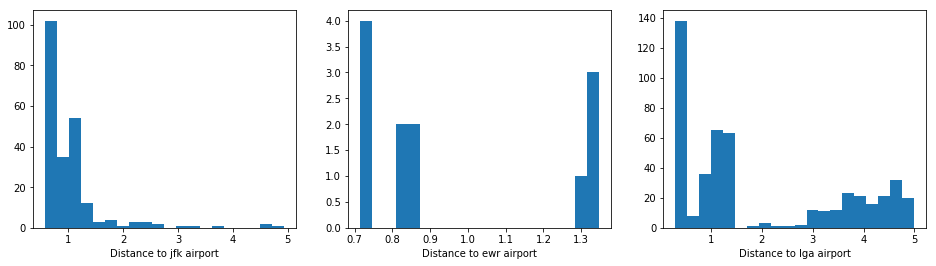

In [16]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(131)
airport_jfk = test_df[test_df['jfk_dist'] < 5]
ax1.hist(airport_jfk.jfk_dist, bins=20)
ax1.set_xlabel('Distance to jfk airport')
ax2 = plt.subplot(132)
airport_ewr = test_df[test_df['ewr_dist'] < 5]
ax2.hist(airport_ewr.ewr_dist, bins=20)
ax2.set_xlabel('Distance to ewr airport')
ax3 = plt.subplot(133)
airport_lga = test_df[test_df['lga_dist'] < 5]
ax3.hist(airport_lga.lga_dist, bins=20)
ax3.set_xlabel('Distance to lga airport')
plt.show()

The test set contain significant samples of pickups and drops near to the 3 airports.

## Read Training Set

In [91]:
%%time
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'
        }
#train_df = read_feather('tmp/train100K.feather')
train_df = read_csv('train1.csv', parse_dates=['pickup_datetime'],
                    infer_datetime_format=True, dtype=types)
train_df = train_df.drop('key', axis=1)
print(train_df.shape)

(2000000, 7)
CPU times: user 16.5 s, sys: 926 ms, total: 17.4 s
Wall time: 17.2 s


In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 55.3 MB


In [93]:
train_df = transform(train_df)

Maximum fare_amount: 200.0
(1927353, 13)


In [22]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,dayofweek,period
count,963317.000000,963317.000000,963317.000000,963317.000000,963317.000000,963317.000000,963317.000000,963317.000000,963317.000000
mean,11.315085,-73.975441,40.750980,-73.974625,40.751369,1.690716,3.366995,3.038593,0.429817
std,9.476092,0.035680,0.027719,0.034440,0.031037,1.306800,3.765480,1.948161,0.495050
min,2.500000,-74.252182,40.573395,-74.259460,40.570103,1.000000,0.000768,0.000000,0.000000
25%,6.000000,-73.992279,40.736599,-73.991577,40.735580,1.000000,1.280282,1.000000,0.000000
50%,8.500000,-73.982124,40.753376,-73.980652,40.753899,1.000000,2.176609,3.000000,0.000000
75%,12.500000,-73.968445,40.767536,-73.965530,40.768406,2.000000,3.941896,5.000000,1.000000
max,200.000000,-73.137390,41.650002,-73.105865,41.566666,6.000000,114.780777,6.000000,1.000000


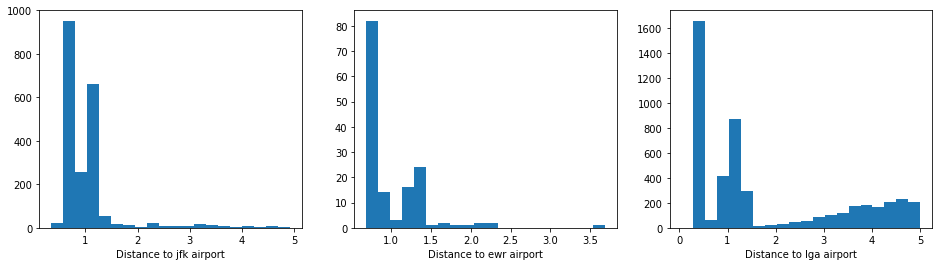

In [165]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(131)
airport_jfk = train_df[train_df['jfk_dist'] < 5]
ax1.hist(airport_jfk.jfk_dist, bins=20)
ax1.set_xlabel('Distance to jfk airport')
ax2 = plt.subplot(132)
airport_ewr = train_df[train_df['ewr_dist'] < 5]
ax2.hist(airport_ewr.ewr_dist, bins=20)
ax2.set_xlabel('Distance to ewr airport')
ax3 = plt.subplot(133)
airport_lga = train_df[train_df['lga_dist'] < 5]
ax3.hist(airport_lga.lga_dist, bins=20)
ax3.set_xlabel('Distance to lga airport')
plt.show()

All rides with minimum distances (dropoff or pickup) to JKF airport less than ~1.5 km should be marked as 1. These rides will likely have fixed fare amounts.

In [166]:
fares_jfk = train_df[train_df['jfk_ride'] == 1]
print(fares_jfk.shape)
fares_jfk.fare_amount.value_counts().head(10)

(1949, 19)


57.33    381
49.80    209
45.00    181
52.00    145
49.57    132
56.80     86
57.54     54
49.15     45
2.50      17
50.50     12
Name: fare_amount, dtype: int64

In [167]:
fares_ewr = train_df[train_df['ewr_ride'] == 1]
print(fares_ewr.shape)
fares_ewr.fare_amount.value_counts().head(10)

(140, 19)


85.00    3
77.00    3
76.50    3
60.30    3
61.90    3
87.75    2
79.00    2
58.30    2
61.67    2
71.75    2
Name: fare_amount, dtype: int64

In [168]:
fares_lga = train_df[train_df['lga_ride'] == 1]
print(fares_lga.shape)
fares_lga.fare_amount.value_counts().head(10)

(3317, 19)


30.50    45
25.70    41
28.50    40
26.90    40
26.50    39
26.10    39
35.83    38
27.30    38
27.70    38
24.50    36
Name: fare_amount, dtype: int64

In [169]:
NoDispLong = train_df[train_df.pickup_longitude == train_df.dropoff_longitude]
print(NoDispLong.shape)
NoDispLat = train_df[train_df.pickup_latitude == train_df.dropoff_latitude]
print(NoDispLat.shape)
NoDisp = train_df[(train_df.pickup_longitude == train_df.dropoff_longitude) &
                 (train_df.pickup_latitude == train_df.dropoff_latitude)]
print(NoDisp.shape)

(1013, 19)
(1017, 19)
(997, 19)


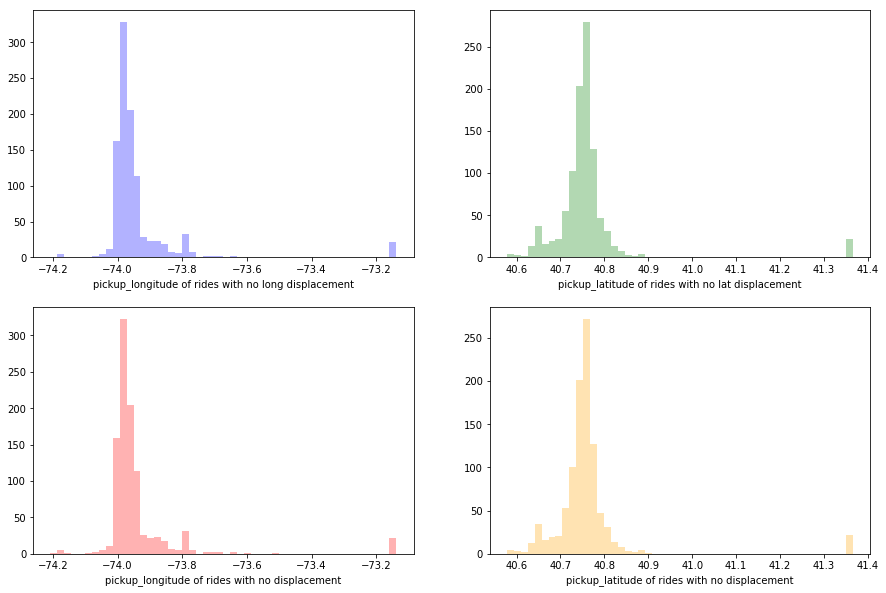

In [170]:
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
ax1.hist(NoDispLong.pickup_longitude, bins=50, color = 'b', alpha = 0.3)
ax1.set_xlabel('pickup_longitude of rides with no long displacement')
ax2 = plt.subplot(222)
ax2.hist(NoDispLat.pickup_latitude, bins=50, color = 'g', alpha = 0.3)
ax2.set_xlabel('pickup_latitude of rides with no lat displacement')
ax3 = plt.subplot(223)
ax3.hist(NoDisp.pickup_longitude, bins=50, color = 'r', alpha = 0.3)
ax3.set_xlabel('pickup_longitude of rides with no displacement')
ax4 = plt.subplot(224)
ax4.hist(NoDisp.pickup_latitude, bins=50, color = 'orange', alpha = 0.3)
ax4.set_xlabel('pickup_latitude of rides with no displacement')
plt.show()

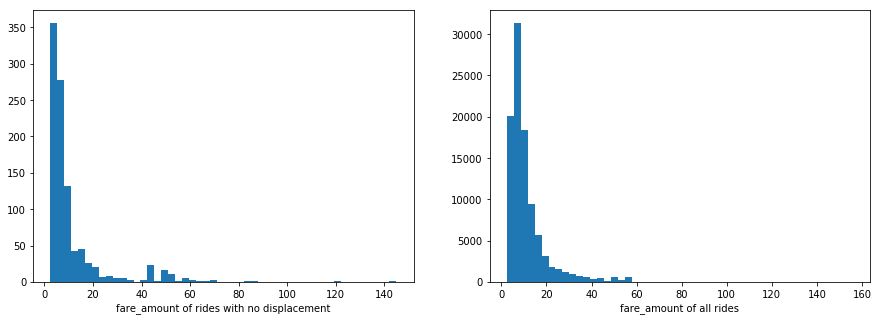

In [171]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.hist(NoDisp.fare_amount, bins=50)
ax1.set_xlabel('fare_amount of rides with no displacement')
ax2 = plt.subplot(122)
ax2.hist(train_df.fare_amount, bins=50)
ax2.set_xlabel('fare_amount of all rides')
plt.show()

Rides with no displacements introduce a noise in the model. They could be a taxi ride as a city tour or simply a error in the GPS data acquisition. There is no information in the dataset to better identify these rides.

In [8]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [12]:
print('Old size: %d' % len(train_df))
train_df = train_df[select_within_boundingbox(train_df, BB)]
print('New size: %d' % len(train_df))

Old size: 1949939
New size: 1949939


In [13]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

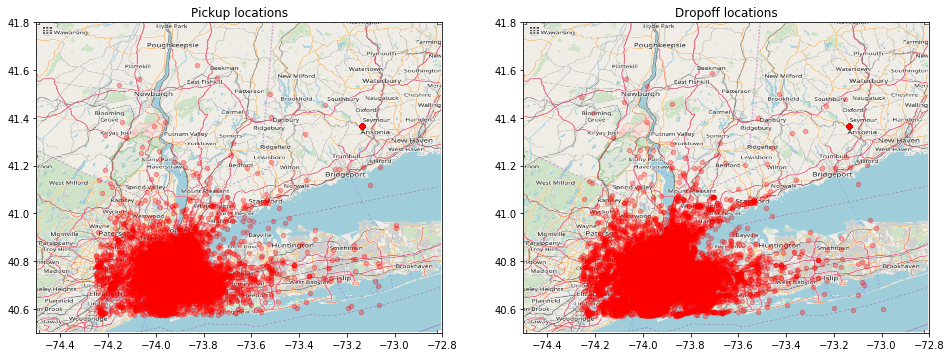

In [22]:
# plot training data on map
plot_on_map(train_df, BB, nyc_map, s=20, alpha=0.3)

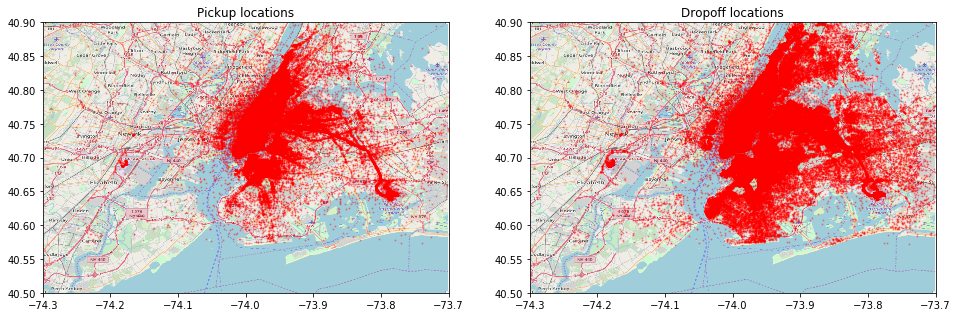

In [17]:
# plot training data on map zoomed in
plot_on_map(train_df, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

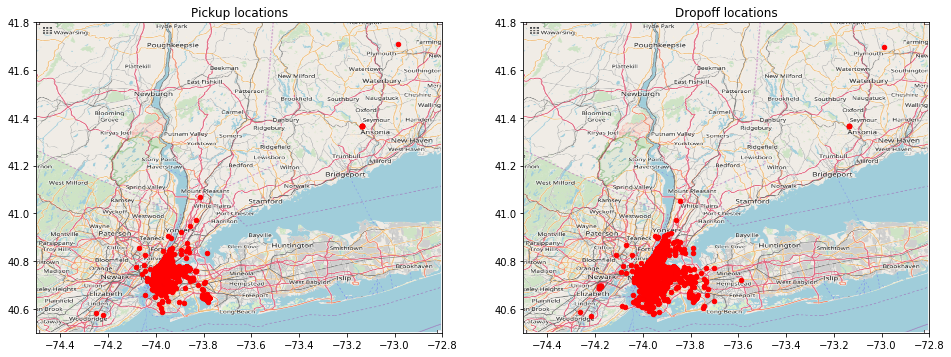

In [21]:
# plot test data on map
plot_on_map(test_df, BB, nyc_map, alpha=1.0, s=20)

In [23]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

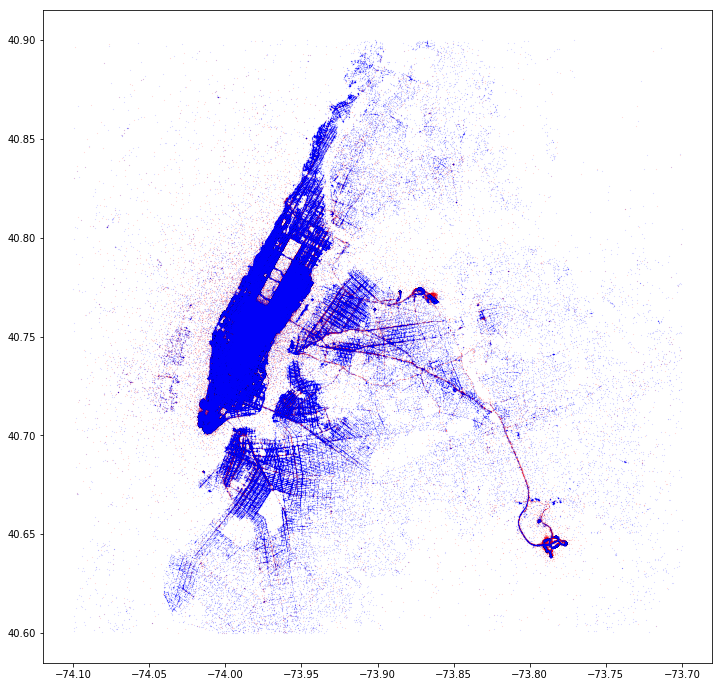

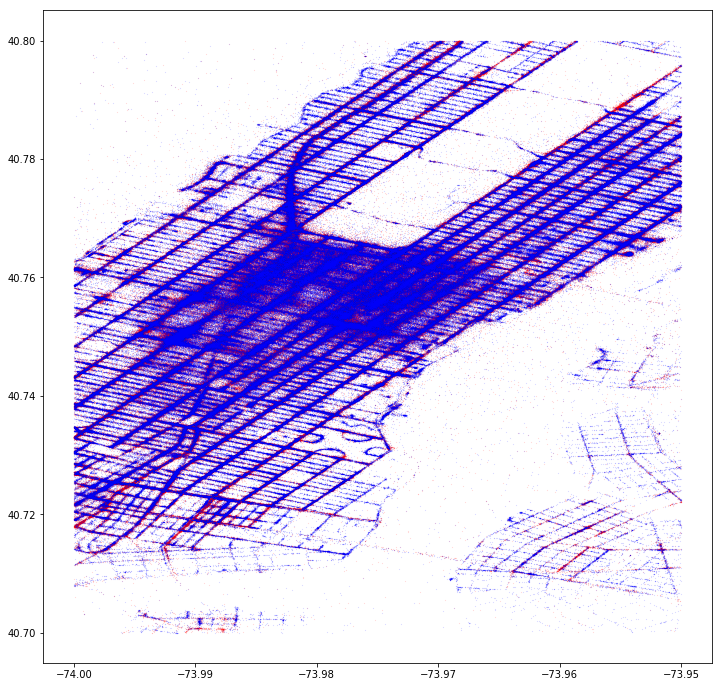

In [24]:
plot_hires(train_df, (-74.1, -73.7, 40.6, 40.9))
plot_hires(train_df, (-74, -73.95, 40.7, 40.8))

In [94]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,weekend,year,8pmto6am,rushhour,jfk_dist,jfk_ride,period
0,34.669998,-73.870819,40.773991,-73.999054,40.760658,10.900634,0,2009,0,1,16.821121,0,0
1,4.000000,-74.004051,40.752945,-74.001144,40.746910,0.714324,0,2014,0,1,22.207367,0,1
2,3.300000,-73.980865,40.750500,-73.981079,40.755962,0.607685,1,2009,1,0,21.016106,0,0
3,7.300000,-73.979965,40.743340,-73.988792,40.759567,1.951639,0,2011,1,0,20.497505,0,0
4,7.000000,-73.993851,40.720497,-74.007256,40.726669,1.321783,0,2014,0,0,20.229820,0,1


## Train the Model

In [95]:
X = train_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].values
#X = train_df.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,14,15,17]].values
#y = np.log10(train_df.iloc[:,0].values)
y = train_df.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.005, random_state=seed)
print(X_train.shape)
print(X_test.shape)

(1917716, 12)
(9637, 12)


In [97]:
%%time

model=xgb.XGBRegressor(colsample_bytree=0.8,
                         gamma=0,
                         learning_rate=0.05,
                         max_depth=15,
                         min_child_weight=1,
                         n_estimators=200,
                         objective= "reg:linear",
                         nthread=-1)

#scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
#print('RMSE CV: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))

model.fit(X_train,y_train)
y_pred = model.predict(X_train)
print('RMSE before gridsearch train set: %.4f' % np.sqrt(mean_squared_error(y_pred,y_train)))
y_pred_test = model.predict(X_test)
print('RMSE before gridsearch test set: %.4f' % np.sqrt(mean_squared_error(y_pred_test,y_test)))

RMSE before gridsearch train set: 2.2581
RMSE before gridsearch test set: 3.2605
CPU times: user 51min 13s, sys: 4min 3s, total: 55min 16s
Wall time: 15min 27s


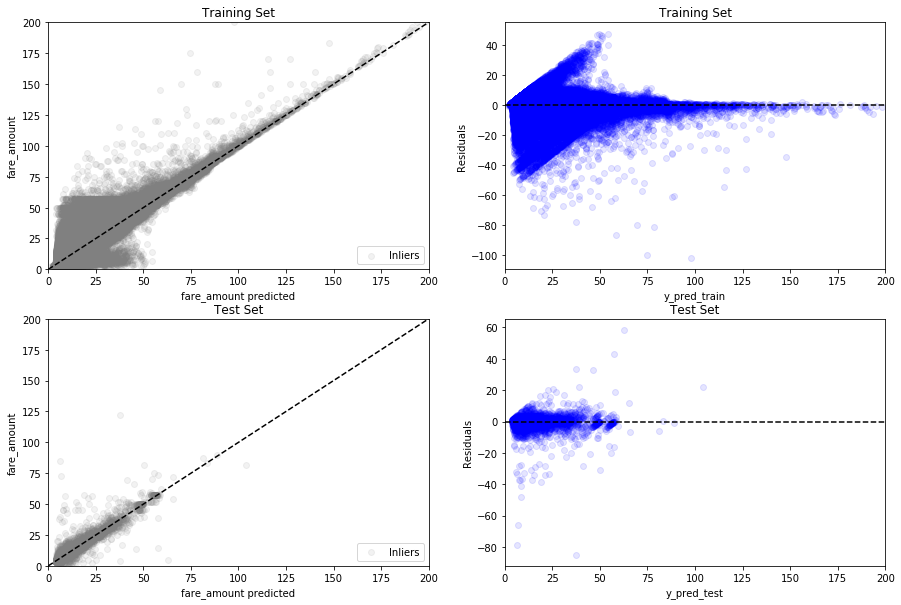

In [98]:
#inlier_mask = ransac1.inlier_mask_
#outlier_mask = np.logical_not(inlier_mask)

plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
ax1.scatter(y_pred, y_train,
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
#ax1.scatter(y_pred[outlier_mask], y_train[outlier_mask],
#            c='red', alpha=0.3,
#            marker='s', label='Outliers')
ax1.set_xlim(0,200)
ax1.set_ylim(0,200)
ax1.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax1.set_title('Training Set')
ax1.set_xlabel('fare_amount predicted')
ax1.set_ylabel('fare_amount')
ax1.legend(loc='lower right')

ax2 = plt.subplot(222)
ax2.scatter(y_pred, y_pred - y_train, c = 'blue', alpha = 0.1)
ax2.set_xlim(0,200)
ax2.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax2.set_title('Training Set')
ax2.set_xlabel('y_pred_train')
ax2.set_ylabel('Residuals')

ax3 = plt.subplot(223)
ax3.scatter(y_pred_test, y_test,
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
ax3.set_xlim(0,200)
ax3.set_ylim(0,200)
ax3.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax3.set_title('Test Set')
ax3.set_xlabel('fare_amount predicted')
ax3.set_ylabel('fare_amount')
ax3.legend(loc='lower right')

ax4 = plt.subplot(224)
ax4.scatter(y_pred_test, y_pred_test - y_test, c = 'blue', alpha = 0.1)
ax4.set_xlim(0,200)
ax4.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax4.set_title('Test Set')
ax4.set_xlabel('y_pred_test')
ax4.set_ylabel('Residuals')


#plt.subplots_adjust(wspace=0.4, top=0.5)
plt.show()

## Find outliers

In [ ]:
#train_df.groupby('fare_amount').count()
fare_freq = P1['fare_amount'].value_counts()
#fare_freq = fare_freq[(fare_freq[:,]>100) & (fare_freq[:,]<1000)]
fare_freq = fare_freq[(fare_freq[:,]>100) & (fare_freq[:,]<400)]
draw_barchart(fare_freq, 'fare_freq')

In [ ]:
#fare_freq[fare_freq[:,]<2]
#fare_freq[:45]
#print(fare_low.shape)

In [ ]:
P1.head()

In [ ]:
P1.describe()

In [ ]:
from sklearn.model_selection import train_test_split

X = P1.iloc[:,1:].values
#y = np.log10(P1.iloc[:,0].values)
y = P1.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.4, random_state=seed)

In [ ]:
%%time
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

#model = RandomForestRegressor(random_state=seed, n_estimators=15,
#                              max_depth = 15, n_jobs = -1)
model = ExtraTreesRegressor(random_state=seed, n_estimators=15,
                              max_depth = 15, n_jobs = -1)

#scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
#print('RMSE CV: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))

ransac1 = RANSACRegressor(model,
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_loss',
                         residual_threshold=200,
                         random_state=0)

#scores = cross_val_score(ransac1, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
#print('RMSE CV with RANSAC: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)), np.sqrt(np.std(scores))))

ransac1.fit(X_train, y_train)
y_pred = ransac1.predict(X_train)
print('RMSE before gridsearch train set: %.4f' % np.sqrt(mean_squared_error(y_pred,y_train)))
y_pred_test = ransac1.predict(X_test)
print('RMSE before gridsearch test set: %.4f' % np.sqrt(mean_squared_error(y_pred_test,y_test)))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

inlier_mask = ransac1.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

plt.figure(figsize=(15, 10))
ax1 = plt.subplot(221)
ax1.scatter(y_pred[inlier_mask], y_train[inlier_mask],
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
ax1.scatter(y_pred[outlier_mask], y_train[outlier_mask],
            c='red', alpha=0.3,
            marker='s', label='Outliers')
ax1.set_xlim(0,200)
ax1.set_ylim(0,200)
ax1.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax1.set_title('Training Set')
ax1.set_xlabel('fare_amount predicted')
ax1.set_ylabel('fare_amount')
ax1.legend(loc='lower right')

ax2 = plt.subplot(222)
ax2.scatter(y_pred, y_pred - y_train, c = 'blue', alpha = 0.1)
ax2.set_xlim(0,200)
ax2.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax2.set_title('Training Set')
ax2.set_xlabel('y_pred_train')
ax2.set_ylabel('Residuals')

ax3 = plt.subplot(223)
ax3.scatter(y_pred_test, y_test,
            c='gray', alpha=0.1,
            marker='o', label='Inliers')
ax3.set_xlim(0,200)
ax3.set_ylim(0,200)
ax3.plot((0,200),(0,200), c = 'black', linestyle = 'dashed')
ax3.set_title('Test Set')
ax3.set_xlabel('fare_amount predicted')
ax3.set_ylabel('fare_amount')
ax3.legend(loc='lower right')

ax4 = plt.subplot(224)
ax4.scatter(y_pred_test, y_pred_test - y_test, c = 'blue', alpha = 0.1)
ax4.set_xlim(0,200)
ax4.plot((0,200),(0,0), c = 'black', linestyle = 'dashed')
ax4.set_title('Test Set')
ax4.set_xlabel('y_pred_test')
ax4.set_ylabel('Residuals')


#plt.subplots_adjust(wspace=0.4, top=0.5)
plt.show()

In [ ]:
print('Number of outliers: %.i'% y_pred[outlier_mask].shape)

## Train Model with no outliers

In [ ]:
from sklearn.model_selection import train_test_split

X = P1.iloc[:,1:].values
y = np.log10(P1.iloc[:,0].values)
#y = P1.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3, random_state=seed)

In [ ]:
%%time
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

modelP1=xgb.XGBRegressor(colsample_bytree=0.8,
                         gamma=0,
                         learning_rate=0.05,
                         max_depth=20,
                         min_child_weight=1,
                         n_estimators=300,
                         objective= "reg:linear",
                         nthread=-1)

modelP1.fit(X_train,y_train)
y_pred = modelP1.predict(X_test)
print('RMSE before gridsearch: %.4f' % np.sqrt(mean_squared_error(y_pred,y_test)))

## Make predictions on the test set

In [100]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)

test_df['dist'] = distance(test_df['pickup_latitude'], test_df['pickup_longitude'],
                           test_df['dropoff_latitude'], test_df['dropoff_longitude'])

print('Minimum ride distance: %.1f' % test_df['dist'].min())
print('Maximum ride distance: %.1f' % test_df['dist'].max())

test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek.astype('uint8')
test_df['weekend'] = np.where(test_df.dayofweek < 5,0,1).astype('uint8')
#test_df = test_df.drop(['dayofweek'], axis=1)
test_df['hour'] = test_df['pickup_datetime'].dt.hour.astype('uint8')
#test_df['month'] = test_df['pickup_datetime'].dt.month.astype('uint8')
test_df['year'] = test_df['pickup_datetime'].dt.year.astype('uint16')
# Create features for special rates
test_df['8pmto6am'] = np.where((test_df['hour'] >= 6) &
                                   (test_df['hour'] < 20),0,1).astype('uint8')
#train_df['holiday'] = 
test_df['rushhour'] = np.where((test_df['hour'] >= 16) &
                                    (test_df['hour'] < 20) &
                                    (test_df['weekend'] == 0),1,0).astype('uint8')
test_df = test_df.drop(['hour','weekend'], axis=1)

# Add minimum distances to the airports
add_airport_dist(test_df)
# Add categorical variables
test_df['jfk_ride'] = np.where(test_df['jfk_dist'] < 1.5,1,0)
#test_df['ewr_ride'] = np.where(test_df['ewr_dist'] < 1.5,1,0)
#test_df['lga_ride'] = np.where(test_df['lga_dist'] < 1.5,1,0)
# Add period
test_df['period'] = np.where(test_df['pickup_datetime'] < '2012-09-01',0,1)
test_df = test_df.drop(['passenger_count'], axis=1)
test_df.head()

Minimum ride distance: 0.0
Maximum ride distance: 100.0


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,dayofweek,year,8pmto6am,rushhour,jfk_dist,jfk_ride,period
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,2.323260,1,2015,0,0,20.630787,0,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,2.425353,1,2015,0,0,19.647702,0,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,0.618628,5,2011,0,0,20.652459,0,0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1.961033,5,2012,1,0,21.747868,0,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,5.387301,5,2012,1,0,21.167442,0,1


In [102]:
X_testF = test_df.iloc[:,2:].values
#X_testF = test_df.iloc[:,2:].values
# For model in log
#y_predF = 10**(model.predict(X_testF).round(4))
y_predF = model.predict(X_testF).round(4)

In [103]:
from pandas import DataFrame

submission = DataFrame({'key': test_df.key, 'fare_amount': y_predF},
                       columns = ['key', 'fare_amount'])

submission.to_csv('submission.csv', index = False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.6945
1,2015-01-27 13:08:24.0000003,10.6629
2,2011-10-08 11:53:44.0000002,4.5895
3,2012-12-01 21:12:12.0000002,7.7371
4,2012-12-01 21:12:12.0000003,14.6654
